In [1]:
import numpy as np 
import pandas as pd
import os
import torchvision
import time
import datetime

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch
#from torch import device
import torch.nn as nn
import cv2
#from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid

from torchvision import models
from collections import namedtuple

import matplotlib.pyplot as plt
from IPython.display import Image

from glob import glob
from PIL import Image
import pydicom as dicom
import collections
import math
import random

import tifffile as tiff
from tifffile import imsave

In [2]:
import gc
import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
gc.collect()
torch.cuda.empty_cache()

if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
# GLOBAL SETTINGS
img_size = (320,320)

NUM_EPOCHS = 300
BATCH_SIZE = 16

b1 = 0.5
b2 = 0.999

SEED = 35

In [4]:
PATH = 'D:/style transfer/UNet/'
path_result = "D:/style transfer/MIA/training_result/"

path_new = "D:/style transfer/datasets/spider/train/"

In [5]:
# Seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

t = time.strftime("%H-%M-%S")

def get_date():
    now = time.localtime()
    s = "%04d-%02d-%02d" % (now.tm_year, now.tm_mon, now.tm_mday)
    return s

def make_folder(folder_name):
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

today = get_date()
f = t+"_U34_MRI_320"
work_dir = path_result + today +"/"+f

make_folder(path_result+today)

#create the directory of results
os.chdir(path_result+today)
os.mkdir(f)

In [6]:
def normalize(img, n):  #0~1 float
    if img.max() == img.min():
        return np.zeros(img.shape)
    return ((img - img.min())/(img.max() - img.min()))*n
    
def read_tif(path, img_size, n):    
    img = tiff.imread(path)
    img = cv2.resize(img.astype(np.float32), img_size, interpolation=cv2.INTER_LINEAR)   
    img = normalize(img, n)
    return np.squeeze(np.stack([img[np.newaxis,:,:]])) 

def read(path, img_size, n):    
    dcm = dicom.dcmread(path)
    img = dcm.pixel_array      
    img = cv2.resize(img.astype(np.float32), img_size, interpolation=cv2.INTER_LINEAR)
    img = normalize(img, n)
    return np.squeeze(np.stack([img[np.newaxis,:,:]]))   

def img_crop(img, img_size, img_size_c):
    c = int(img_size[1]/2)
    crop_img = img[0:img_size[0],c-img_size_c[0]//2:c+img_size_c[0]//2]
    crop_img = cv2.resize(crop_img, img_size_c, interpolation=cv2.INTER_AREA)
    #crop_img = np.array(crop_img).clip(0,255.)
    #crop_img = normalize(crop_img, 255.)
    return crop_img

In [7]:
import natsort

data_dir1 = 'D:/style transfer/UNet/standard/'
folders = os.listdir(data_dir1)
folders = natsort.natsorted(folders)

images_paths1 = [] 
masks_paths1 = []
for i in range(len(folders)):
    images_path = natsort.natsorted(glob(data_dir1+folders[i]+'/raw_dicom/*.ima'))
    masks_path = natsort.natsorted(glob(data_dir1+folders[i]+'/label/*.tif'))
    for j in range(len(images_path)):
        images_paths1.append(images_path[j])
        masks_paths1.append(masks_path[j])

df_all1 = pd.DataFrame(data= {'images_path': images_paths1, 'masks_path': masks_paths1})

In [8]:
data_dir2 = 'D:/style transfer/UNet/'
images_paths2 = natsort.natsorted(glob(data_dir2+'raw/*.ima'))
masks_paths2 = natsort.natsorted(glob(data_dir2+'mask/*.tif'))

df_all2 = pd.DataFrame(data= {'images_path': images_paths2, 'masks_path': masks_paths2}) 

In [14]:
# folders1 = os.listdir(path_new+"/images/")
# folders1 = natsort.natsorted(folders1)
# folders2 = os.listdir(path_new+"/masks/")
# folders2 = natsort.natsorted(folders2)

# image_new = [] #1761
# mask_new = []
# for i in range(len(folders1)):
#     img_list = natsort.natsorted(glob(path_new+"/images/"+folders1[i]+'/*.tif'))
#     m_list = natsort.natsorted(glob(path_new+"/masks/"+folders2[i]+'/*.tif'))
#     for j in range(len(img_list)):
#         image_new.append(img_list[j])
#         mask_new.append(m_list[j])

# df_new = pd.DataFrame(data= {'images_path': image_new, 'masks_path': mask_new})

In [9]:
df = pd.concat([df_all1, df_all2], axis=0).reset_index(drop=True)

stan_list = []
mask_list = []

for i in range(len(df)):
    stan_im = read(df['images_path'].iloc[i], img_size, 255.)
    mask_im = read_tif(df['masks_path'].iloc[i],img_size, 1.)
    stan_list.append(stan_im)
    mask_list.append(mask_im)
    
stan_train = stan_list[98:] #1027
mask_train = mask_list[98:]
stan_test = stan_list[:98] #98
mask_test = mask_list[:98]

In [23]:
#dat = pd.read_excel(PATH+'/train.xlsx')

# stan_list1 = []
# mask_list1 = []

# for i in range(len(df)):
#     stan_im = read(df['images_path'].iloc[i], img_size, 255.)
#     mask_im = read_tif(df['masks_path'].iloc[i],img_size, 1.)
#     stan_list1.append(stan_im)
#     mask_list1.append(mask_im)
    
# stan_list2 = []
# mask_list2 = []

# for i in range(len(df_new)):
#     stan_im = read_tif(df_new['images_path'].iloc[i], img_size, 255.)
#     mask_im = read_tif(df_new['masks_path'].iloc[i],img_size, 1.)
#     stan_list2.append(stan_im)
#     mask_list2.append(mask_im)

# stan_list = stan_list1 + stan_list2
# mask_list = mask_list1 + mask_list2

# stan_train = stan_list[580:] #1027
# mask_train = mask_list[580:]
# stan_test = stan_list[:580] #98
# mask_test = mask_list[:580]

In [11]:
# length = 1000

# l = math.ceil(round(length/(10**(len(str(length))-1)),1))
# l = l*10**(len(str(length))-3)

# fig = plt.figure(figsize=(20,20*l))
# #plt.gray()
# plt.subplots_adjust(hspace = 0.2, wspace = 0.01)
# for i in range(length):
#     plt.subplot(10*l,10,i+1)#
#     plt.imshow(stan_list[i], cmap ='bone')
#     plt.imshow(np.ma.masked_where(mask_list[i] == False, mask_list[i]),cmap='autumn', alpha=0.6)
#     plt.axis('off'), plt.title(str(i))
# plt.show()

In [10]:
class ImageDataset(Dataset):
    def __init__(self, stan_input, mask_input):
        super().__init__()
        self.stan = stan_input
        self.mask = mask_input
        #self.transforms = transforms.Compose([transforms.ToTensor()])       
        self.length_dataset = len(self.stan)

    def __len__(self):
        return self.length_dataset
    
    def transform(self, image, mask):
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
    
    def __getitem__(self, idx):                      
        stan_img = self.stan[idx]
        mask_img = self.mask[idx]  
        
        stan_img = Image.fromarray(stan_img)
        mask_img = Image.fromarray(mask_img)
        
#         stan_img = self.transforms(stan_img)
#         mask_img = self.transforms(mask_img) 
        stan_im, mask_im = self.transform(stan_img, mask_img)

        return {"stan": stan_im, "mask": mask_im}

data_set = ImageDataset(stan_train, mask_train) #############
data_loader = torch.utils.data.DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

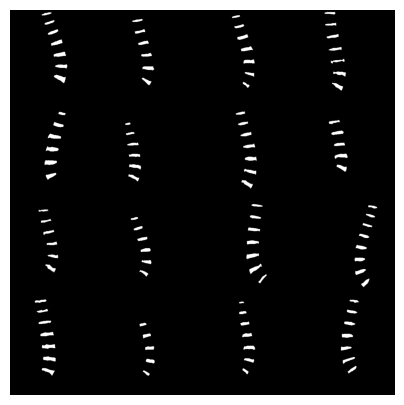

In [11]:
dataiter = iter(data_loader)
images = next(dataiter)
grid = make_grid(images['mask']/1., nrow=4).permute(1, 2, 0).detach().numpy()
#grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(5, 5))
plt.imshow(grid)
plt.axis('off')
plt.show()

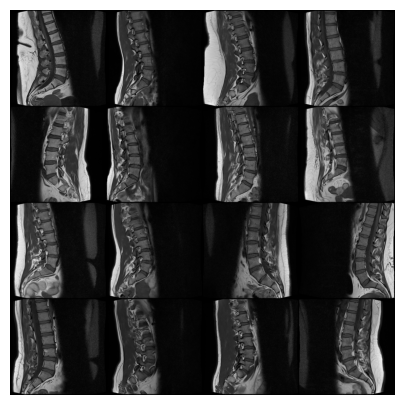

In [12]:
grid = make_grid(images['stan']/255., nrow=4).permute(1, 2, 0).detach().numpy()
#grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(5, 5))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [13]:
class TestDataset(Dataset):
    def __init__(self, test, label):
        super().__init__()
        self.test = test
        self.label = label
        self.transforms = transforms.Compose([transforms.ToTensor()])       
        self.length_dataset = len(self.test)

    def __len__(self):
        return self.length_dataset
    
    def transform(self, image, mask):
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
    
    def __getitem__(self, idx):                      
        test_img = self.test[idx]
        label_img = self.label[idx]  
        
        test_img = Image.fromarray(test_img)
        label_img = Image.fromarray(label_img)
        
        test_im, label_im = self.transform(test_img, label_img)

        return {"test": test_im, "label": label_im}

data_set = TestDataset(stan_test, mask_test) #############
test_loader = torch.utils.data.DataLoader(data_set, batch_size=2, shuffle=True, num_workers=0)

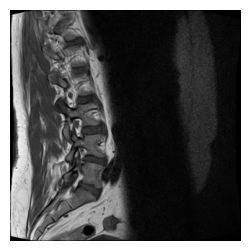

In [28]:
dataiter = iter(test_loader)
images = next(dataiter)
grid = make_grid(images['test']/255, nrow=1).permute(1, 2, 0).detach().numpy()
fig = plt.figure(figsize=(5, 3))
plt.imshow(grid)
plt.axis('off')
plt.show()

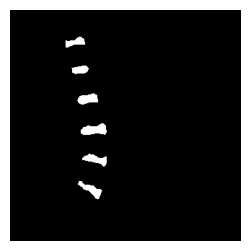

In [29]:
grid = make_grid(images['label']/1., nrow=1).permute(1, 2, 0).detach().numpy()
fig = plt.figure(figsize=(5, 3))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

class Dice_score(nn.Module):
    def __init__(self):
        super(Dice_score, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return dice 
    
class IoU_score(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU_score, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection        
        IoU = (intersection + smooth)/(union + smooth)                
        return IoU

In [16]:
def convert(img, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size_c, interpolation=cv2.INTER_LINEAR) 
    return normalize(img, 1.) #np.array(img/x).clip(0,1)    
    
# # Show image
# def show(img1, img2): 
#     img2 = cv2.resize(img2, img_size_c, interpolation=cv2.INTER_LINEAR)
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,3)) ###########
#     ax1.imshow(convert(img1, img_size), 'gray')
#     ax2.imshow(img2, 'gray')  
#     plt.show()

# Show image
def show(img1, img2): 
    #img2 = cv2.resize(img2, img_size_c, interpolation=cv2.INTER_LINEAR)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,3)) ###########
    ax1.imshow(img1, 'gray')
    ax2.imshow(img2, 'gray')  
    plt.show()

    # Preprocessing ~ Tensor to Image
def ttoi(tensor):
    # Remove the batch_size dimension
    #tensor = tensor.squeeze()
    img = tensor.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

In [17]:
os.chdir(work_dir)
os.mkdir("model")
path_u = "/model/unet/"
make_folder(work_dir+path_u)

In [18]:
import segmentation_models_pytorch as smp
model =  smp.Unet(encoder_name='resnet34', encoder_weights="imagenet", in_channels=1, activation='sigmoid').to(device)
#model =  smp.UnetPlusPlus(encoder_name='resnet50', encoder_weights="imagenet", in_channels=1, activation='sigmoid').to(device)
#model = smp.DeepLabV3(encoder_name ='resnet34', encoder_weights="imagenet", in_channels=1, activation='sigmoid').to(device)

In [19]:
import segmentation_models_pytorch.utils.metrics
import torch.optim as optim

sample_interval = 250
#optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-3, lr = 0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#criterion = DiceLoss().to(device)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

Dice = Dice_score().to(device)
IoU = smp.utils.metrics.IoU(threshold=0.5).to(device)

criterion_Dice = smp.utils.losses.DiceLoss().to(device)
criterion_Jac = smp.utils.losses.JaccardLoss().to(device)
#criterion_F = smp.utils.losses.FocalLoss().to(device)

cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

[Epoch 1/300] [Batch 0/65] ETA: 13:39:04.941688
[Train_Dice: 0.958] [Train_dice: 0.042] [Train_iou: 0.022]


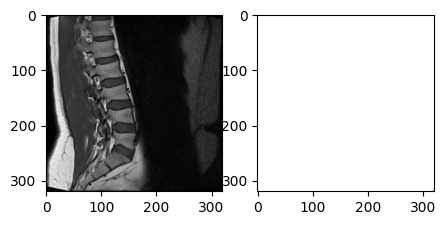

[dice: 0.053] [iou: 0.027]

[Epoch 4/300] [Batch 55/65] ETA: 0:22:15.937619
[Train_Dice: 0.076] [Train_dice: 0.924] [Train_iou: 0.860]


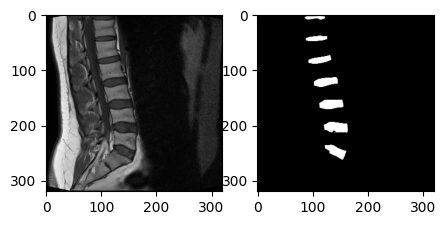

[dice: 0.927] [iou: 0.866]

[Epoch 8/300] [Batch 45/65] ETA: 0:22:19.652061
[Train_Dice: 0.076] [Train_dice: 0.924] [Train_iou: 0.859]


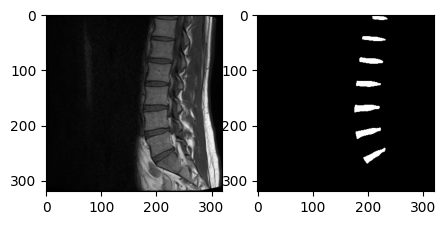

[dice: 0.913] [iou: 0.841]

[Epoch 12/300] [Batch 35/65] ETA: 0:21:45.963099
[Train_Dice: 0.075] [Train_dice: 0.925] [Train_iou: 0.861]


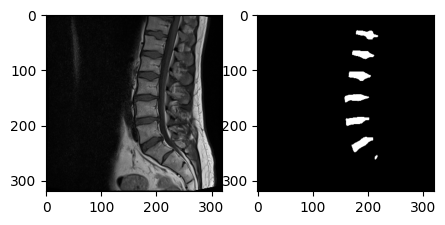

[dice: 0.917] [iou: 0.848]

[Epoch 16/300] [Batch 25/65] ETA: 0:21:25.952330
[Train_Dice: 0.077] [Train_dice: 0.923] [Train_iou: 0.858]


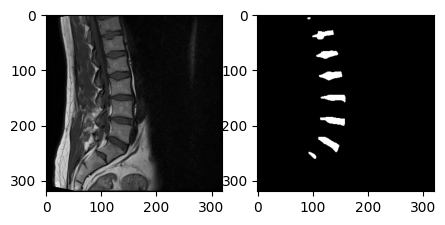

[dice: 0.928] [iou: 0.866]

[Epoch 20/300] [Batch 15/65] ETA: 0:22:12.344890
[Train_Dice: 0.071] [Train_dice: 0.929] [Train_iou: 0.867]


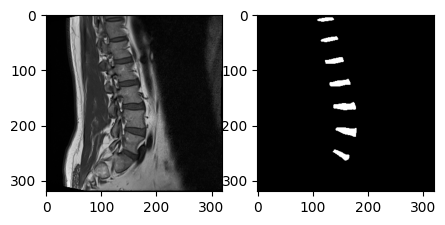

[dice: 0.952] [iou: 0.909]

[Epoch 24/300] [Batch 5/65] ETA: 0:21:00.028839
[Train_Dice: 0.066] [Train_dice: 0.934] [Train_iou: 0.876]


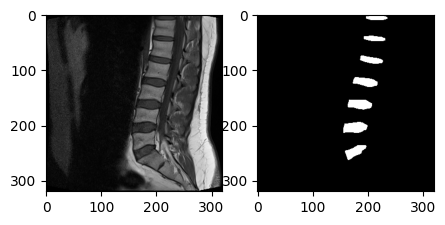

[dice: 0.937] [iou: 0.881]

[Epoch 27/300] [Batch 60/65] ETA: 0:20:07.022548
[Train_Dice: 0.069] [Train_dice: 0.931] [Train_iou: 0.872]


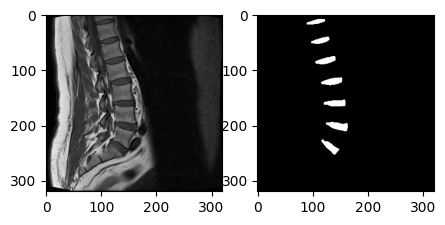

[dice: 0.911] [iou: 0.836]

[Epoch 31/300] [Batch 50/65] ETA: 0:23:30.003901
[Train_Dice: 0.062] [Train_dice: 0.938] [Train_iou: 0.884]


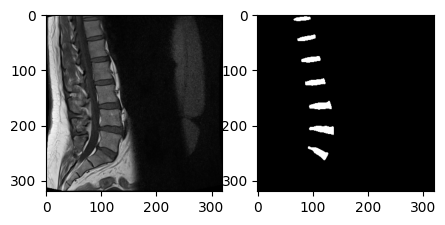

[dice: 0.931] [iou: 0.871]

[Epoch 35/300] [Batch 40/65] ETA: 0:19:19.338892
[Train_Dice: 0.071] [Train_dice: 0.929] [Train_iou: 0.867]


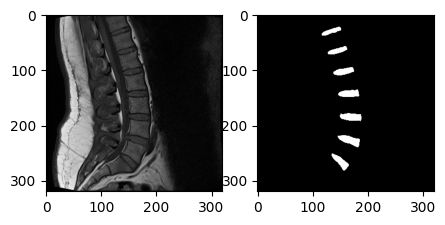

[dice: 0.934] [iou: 0.876]

[Epoch 39/300] [Batch 30/65] ETA: 0:20:09.834814
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.881]


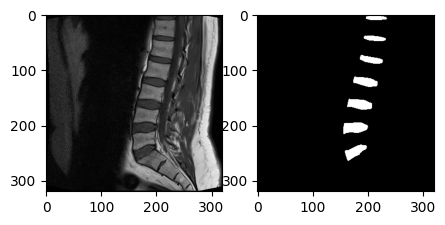

[dice: 0.921] [iou: 0.853]

[Epoch 43/300] [Batch 20/65] ETA: 0:19:28.944657
[Train_Dice: 0.079] [Train_dice: 0.921] [Train_iou: 0.854]


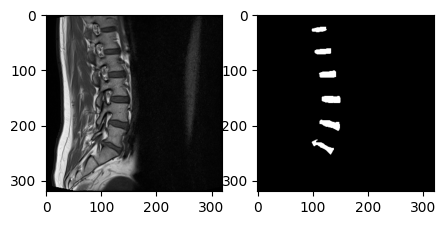

[dice: 0.935] [iou: 0.878]

[Epoch 47/300] [Batch 10/65] ETA: 0:18:59.168859
[Train_Dice: 0.077] [Train_dice: 0.923] [Train_iou: 0.857]


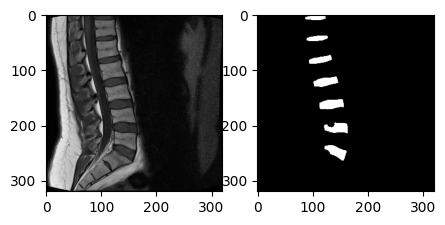

[dice: 0.918] [iou: 0.848]

[Epoch 51/300] [Batch 0/65] ETA: 0:27:36.260192
[Train_Dice: 0.073] [Train_dice: 0.927] [Train_iou: 0.864]


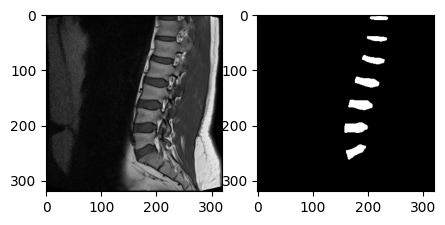

[dice: 0.907] [iou: 0.830]

[Epoch 54/300] [Batch 55/65] ETA: 0:18:52.392883
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.882]


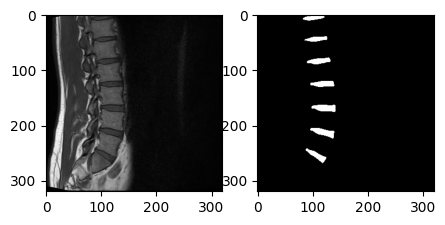

[dice: 0.922] [iou: 0.855]

[Epoch 58/300] [Batch 45/65] ETA: 0:18:32.104475
[Train_Dice: 0.067] [Train_dice: 0.933] [Train_iou: 0.875]


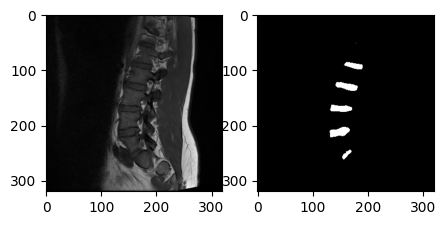

[dice: 0.907] [iou: 0.828]

[Epoch 62/300] [Batch 35/65] ETA: 0:18:23.650093
[Train_Dice: 0.071] [Train_dice: 0.929] [Train_iou: 0.868]


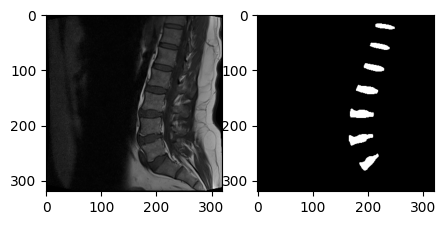

[dice: 0.939] [iou: 0.885]

[Epoch 66/300] [Batch 25/65] ETA: 0:18:11.743052
[Train_Dice: 0.071] [Train_dice: 0.929] [Train_iou: 0.867]


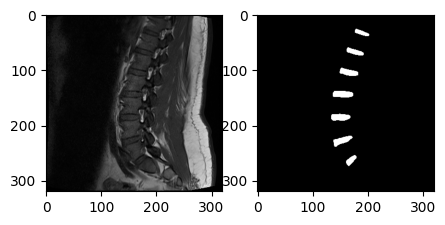

[dice: 0.920] [iou: 0.852]

[Epoch 70/300] [Batch 15/65] ETA: 0:17:30.971746
[Train_Dice: 0.064] [Train_dice: 0.936] [Train_iou: 0.880]


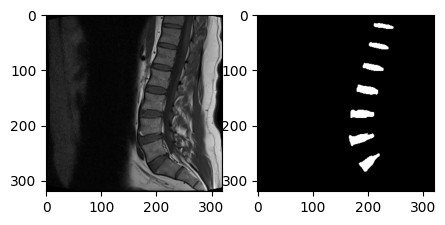

[dice: 0.928] [iou: 0.866]

[Epoch 74/300] [Batch 5/65] ETA: 0:18:33.864303
[Train_Dice: 0.066] [Train_dice: 0.934] [Train_iou: 0.876]


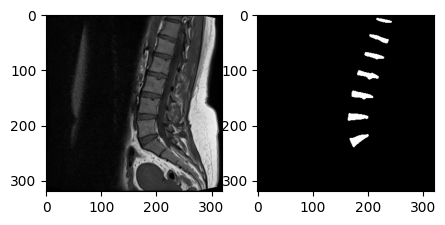

[dice: 0.941] [iou: 0.889]

[Epoch 77/300] [Batch 60/65] ETA: 0:17:03.233771
[Train_Dice: 0.061] [Train_dice: 0.939] [Train_iou: 0.885]


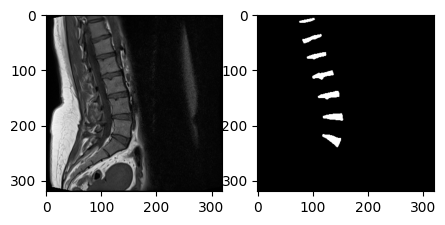

[dice: 0.937] [iou: 0.881]

[Epoch 81/300] [Batch 50/65] ETA: 0:16:57.720759
[Train_Dice: 0.068] [Train_dice: 0.932] [Train_iou: 0.873]


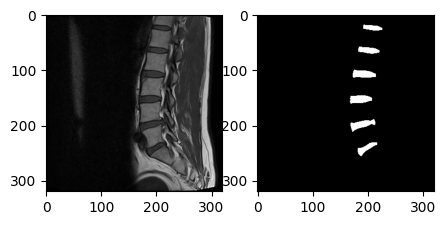

[dice: 0.937] [iou: 0.881]

[Epoch 85/300] [Batch 40/65] ETA: 0:16:19.992390
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.886]


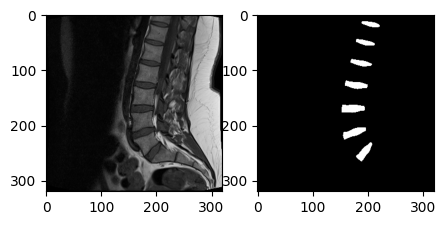

[dice: 0.944] [iou: 0.894]

[Epoch 89/300] [Batch 30/65] ETA: 0:15:55.736041
[Train_Dice: 0.064] [Train_dice: 0.936] [Train_iou: 0.881]


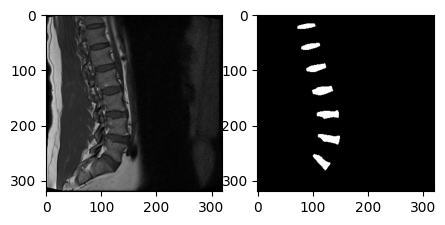

[dice: 0.938] [iou: 0.883]

[Epoch 93/300] [Batch 20/65] ETA: 0:15:52.752829
[Train_Dice: 0.058] [Train_dice: 0.942] [Train_iou: 0.890]


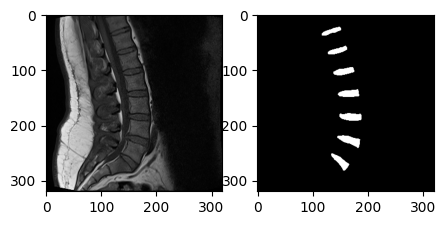

[dice: 0.928] [iou: 0.865]

[Epoch 97/300] [Batch 10/65] ETA: 0:15:20.969367
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.886]


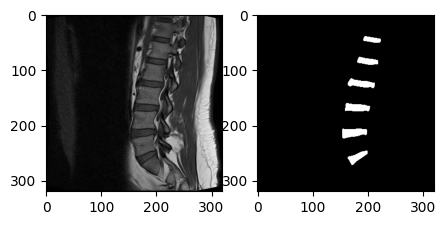

[dice: 0.921] [iou: 0.853]

[Epoch 101/300] [Batch 0/65] ETA: 0:21:55.883398
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.887]


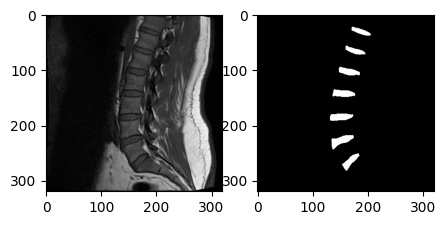

[dice: 0.952] [iou: 0.907]

[Epoch 104/300] [Batch 55/65] ETA: 0:15:10.947919
[Train_Dice: 0.059] [Train_dice: 0.941] [Train_iou: 0.889]


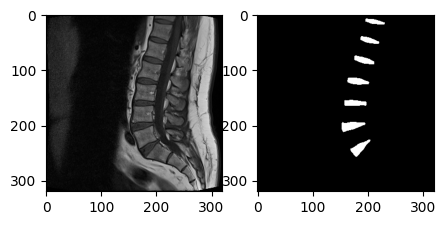

[dice: 0.940] [iou: 0.886]

[Epoch 108/300] [Batch 45/65] ETA: 0:14:18.661532
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.888]


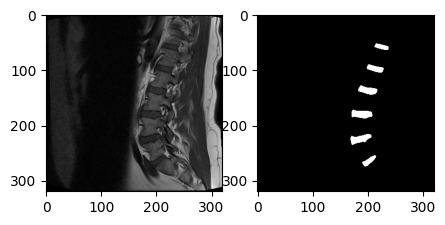

[dice: 0.893] [iou: 0.806]

[Epoch 112/300] [Batch 35/65] ETA: 0:14:38.448844
[Train_Dice: 0.065] [Train_dice: 0.935] [Train_iou: 0.878]


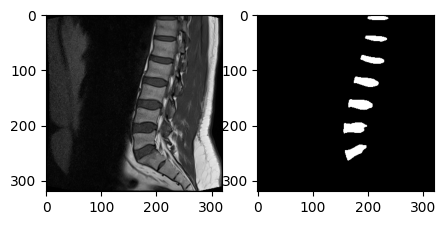

[dice: 0.933] [iou: 0.875]

[Epoch 116/300] [Batch 25/65] ETA: 0:13:54.935188
[Train_Dice: 0.076] [Train_dice: 0.924] [Train_iou: 0.859]


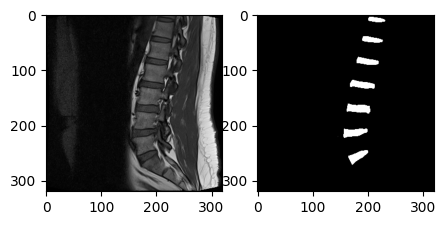

[dice: 0.940] [iou: 0.887]

[Epoch 120/300] [Batch 15/65] ETA: 0:14:00.198576
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.881]


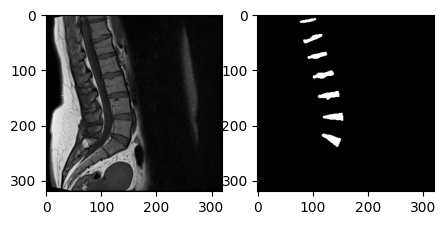

[dice: 0.907] [iou: 0.828]

[Epoch 124/300] [Batch 5/65] ETA: 0:13:15.523524
[Train_Dice: 0.055] [Train_dice: 0.945] [Train_iou: 0.895]


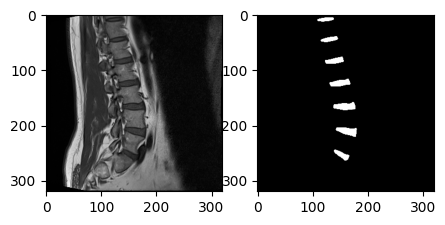

[dice: 0.928] [iou: 0.866]

[Epoch 127/300] [Batch 60/65] ETA: 0:13:02.016814
[Train_Dice: 0.059] [Train_dice: 0.941] [Train_iou: 0.889]


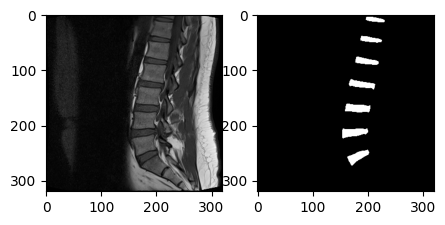

[dice: 0.949] [iou: 0.904]

[Epoch 131/300] [Batch 50/65] ETA: 0:16:24.664679
[Train_Dice: 0.056] [Train_dice: 0.944] [Train_iou: 0.894]


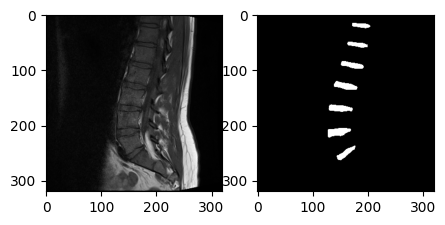

[dice: 0.912] [iou: 0.838]

[Epoch 135/300] [Batch 40/65] ETA: 0:12:35.769670
[Train_Dice: 0.066] [Train_dice: 0.934] [Train_iou: 0.876]


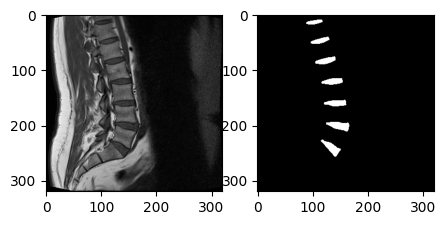

[dice: 0.943] [iou: 0.892]

[Epoch 139/300] [Batch 30/65] ETA: 0:12:29.010801
[Train_Dice: 0.057] [Train_dice: 0.943] [Train_iou: 0.893]


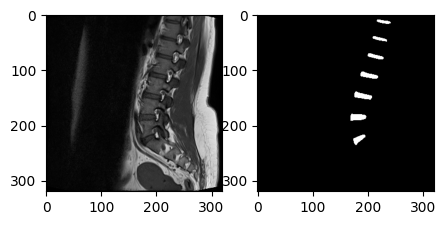

[dice: 0.931] [iou: 0.870]

[Epoch 143/300] [Batch 20/65] ETA: 0:12:03.953366
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.883]


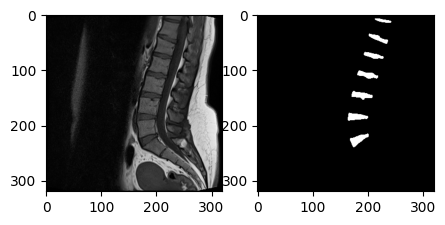

[dice: 0.921] [iou: 0.855]

[Epoch 147/300] [Batch 10/65] ETA: 0:11:45.869198
[Train_Dice: 0.062] [Train_dice: 0.938] [Train_iou: 0.884]


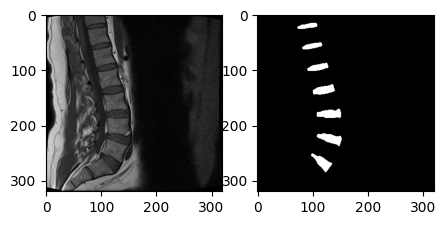

[dice: 0.936] [iou: 0.880]

[Epoch 151/300] [Batch 0/65] ETA: 0:17:01.685958
[Train_Dice: 0.057] [Train_dice: 0.943] [Train_iou: 0.893]


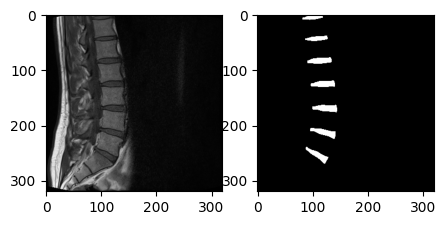

[dice: 0.918] [iou: 0.849]

[Epoch 154/300] [Batch 55/65] ETA: 0:12:45.408039
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.887]


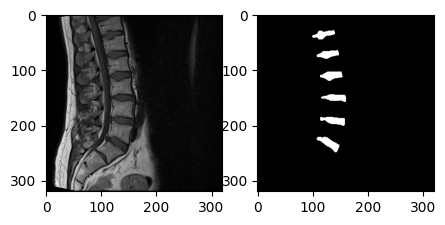

[dice: 0.946] [iou: 0.898]

[Epoch 158/300] [Batch 45/65] ETA: 0:10:56.808257
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.881]


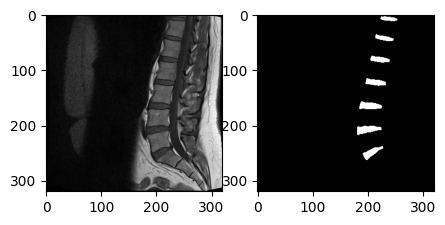

[dice: 0.924] [iou: 0.858]

[Epoch 162/300] [Batch 35/65] ETA: 0:10:39.575958
[Train_Dice: 0.054] [Train_dice: 0.946] [Train_iou: 0.898]


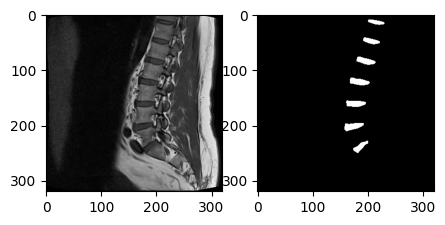

[dice: 0.935] [iou: 0.878]

[Epoch 166/300] [Batch 25/65] ETA: 0:10:25.744462
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.881]


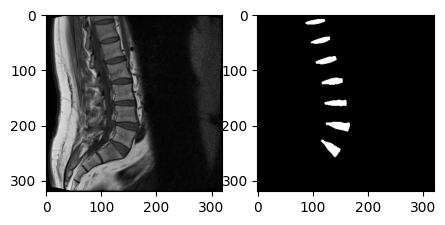

[dice: 0.918] [iou: 0.848]

[Epoch 170/300] [Batch 15/65] ETA: 0:10:12.519026
[Train_Dice: 0.058] [Train_dice: 0.942] [Train_iou: 0.891]


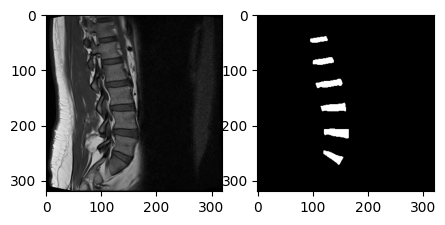

[dice: 0.928] [iou: 0.866]

[Epoch 174/300] [Batch 5/65] ETA: 0:09:32.989225
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.887]


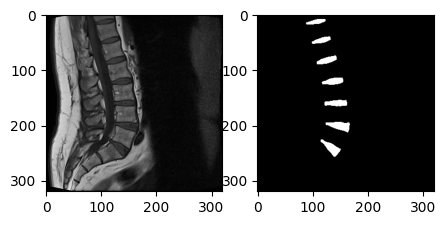

[dice: 0.937] [iou: 0.882]

[Epoch 177/300] [Batch 60/65] ETA: 0:09:25.418243
[Train_Dice: 0.055] [Train_dice: 0.945] [Train_iou: 0.897]


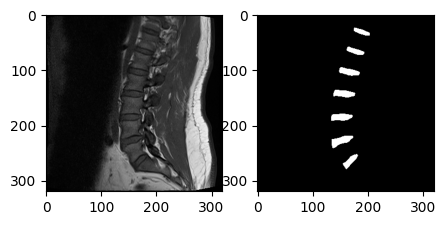

[dice: 0.933] [iou: 0.875]

[Epoch 181/300] [Batch 50/65] ETA: 0:09:25.714538
[Train_Dice: 0.054] [Train_dice: 0.946] [Train_iou: 0.898]


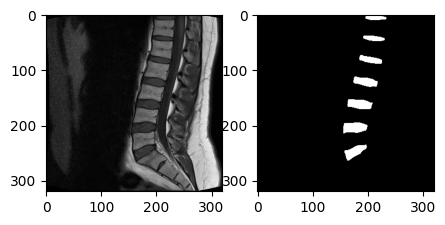

[dice: 0.933] [iou: 0.874]

[Epoch 185/300] [Batch 40/65] ETA: 0:08:49.312491
[Train_Dice: 0.065] [Train_dice: 0.935] [Train_iou: 0.878]


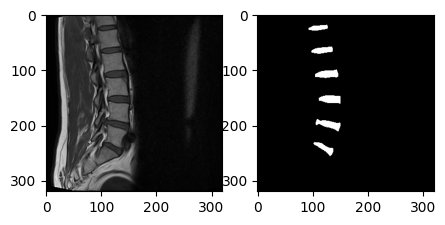

[dice: 0.950] [iou: 0.904]

[Epoch 189/300] [Batch 30/65] ETA: 0:08:30.728419
[Train_Dice: 0.056] [Train_dice: 0.944] [Train_iou: 0.893]


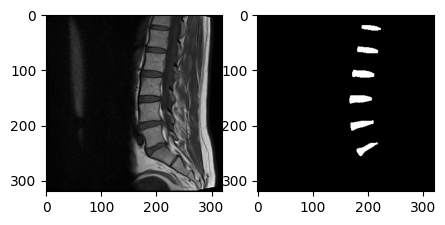

[dice: 0.928] [iou: 0.866]

[Epoch 193/300] [Batch 20/65] ETA: 0:07:49.001055
[Train_Dice: 0.057] [Train_dice: 0.943] [Train_iou: 0.892]


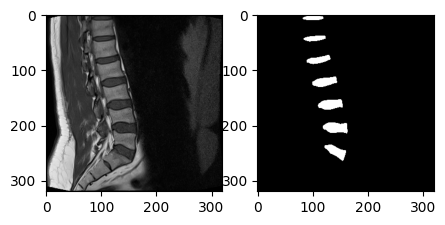

[dice: 0.927] [iou: 0.864]

[Epoch 197/300] [Batch 10/65] ETA: 0:07:35.669224
[Train_Dice: 0.057] [Train_dice: 0.943] [Train_iou: 0.892]


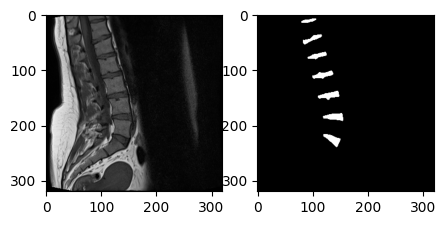

[dice: 0.915] [iou: 0.845]

[Epoch 201/300] [Batch 0/65] ETA: 0:12:43.810873
[Train_Dice: 0.059] [Train_dice: 0.941] [Train_iou: 0.889]


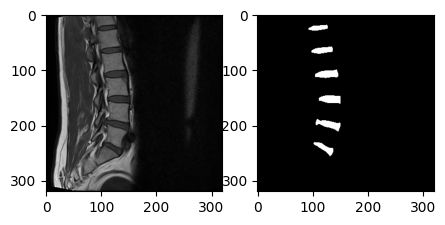

[dice: 0.931] [iou: 0.872]

[Epoch 204/300] [Batch 55/65] ETA: 0:07:14.350967
[Train_Dice: 0.057] [Train_dice: 0.943] [Train_iou: 0.893]


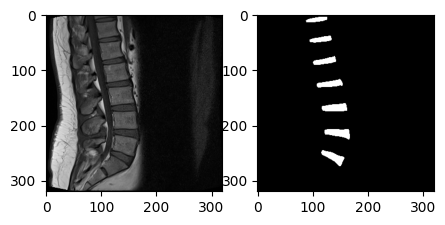

[dice: 0.951] [iou: 0.907]

[Epoch 208/300] [Batch 45/65] ETA: 0:06:51.051750
[Train_Dice: 0.052] [Train_dice: 0.948] [Train_iou: 0.902]


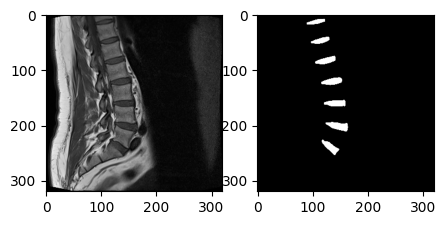

[dice: 0.950] [iou: 0.904]

[Epoch 212/300] [Batch 35/65] ETA: 0:06:16.308441
[Train_Dice: 0.067] [Train_dice: 0.933] [Train_iou: 0.875]


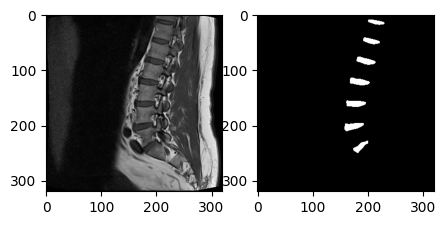

[dice: 0.940] [iou: 0.887]

[Epoch 216/300] [Batch 25/65] ETA: 0:06:11.650577
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.882]


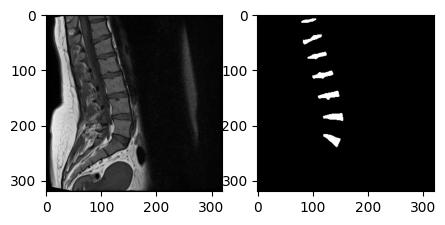

[dice: 0.912] [iou: 0.839]

[Epoch 220/300] [Batch 15/65] ETA: 0:05:54.411900
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.888]


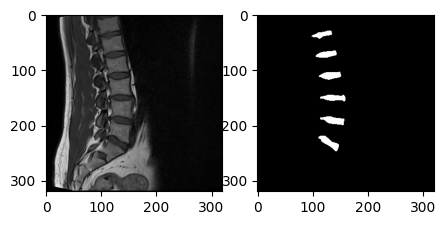

[dice: 0.933] [iou: 0.874]

[Epoch 224/300] [Batch 5/65] ETA: 0:05:42.543125
[Train_Dice: 0.056] [Train_dice: 0.944] [Train_iou: 0.894]


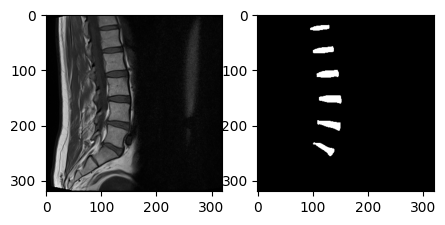

[dice: 0.945] [iou: 0.896]

[Epoch 227/300] [Batch 60/65] ETA: 0:05:30.163360
[Train_Dice: 0.062] [Train_dice: 0.938] [Train_iou: 0.884]


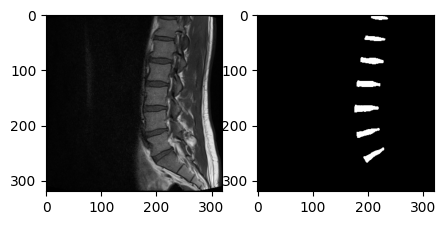

[dice: 0.921] [iou: 0.854]

[Epoch 231/300] [Batch 50/65] ETA: 0:05:53.003383
[Train_Dice: 0.056] [Train_dice: 0.944] [Train_iou: 0.894]


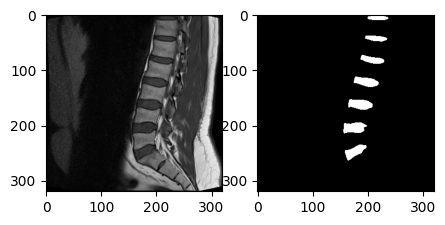

[dice: 0.928] [iou: 0.866]

[Epoch 235/300] [Batch 40/65] ETA: 0:04:57.251463
[Train_Dice: 0.064] [Train_dice: 0.936] [Train_iou: 0.880]


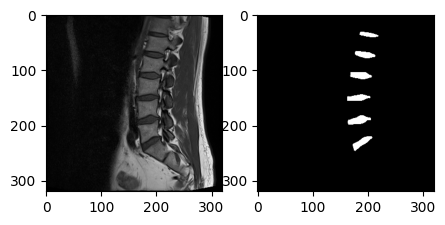

[dice: 0.943] [iou: 0.892]

[Epoch 239/300] [Batch 30/65] ETA: 0:04:52.101860
[Train_Dice: 0.064] [Train_dice: 0.936] [Train_iou: 0.881]


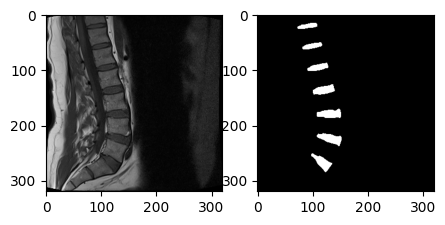

[dice: 0.926] [iou: 0.862]

[Epoch 243/300] [Batch 20/65] ETA: 0:04:13.153145
[Train_Dice: 0.062] [Train_dice: 0.938] [Train_iou: 0.884]


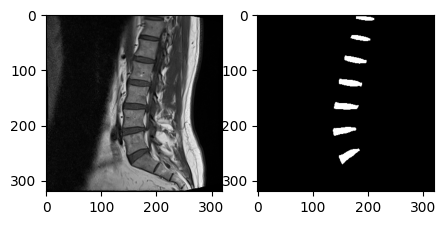

[dice: 0.924] [iou: 0.858]

[Epoch 247/300] [Batch 10/65] ETA: 0:04:00.023017
[Train_Dice: 0.057] [Train_dice: 0.943] [Train_iou: 0.892]


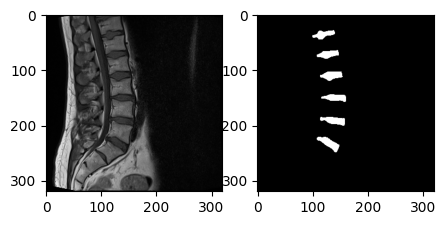

[dice: 0.936] [iou: 0.881]

[Epoch 251/300] [Batch 0/65] ETA: 0:05:49.155962
[Train_Dice: 0.056] [Train_dice: 0.944] [Train_iou: 0.894]


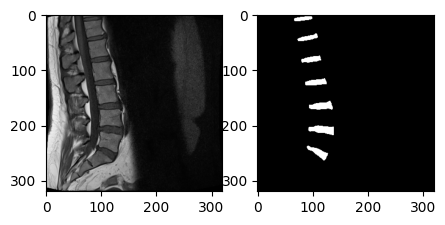

[dice: 0.942] [iou: 0.890]

[Epoch 254/300] [Batch 55/65] ETA: 0:03:28.537102
[Train_Dice: 0.061] [Train_dice: 0.939] [Train_iou: 0.885]


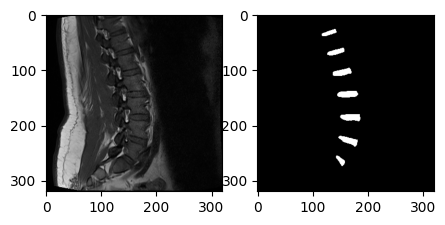

[dice: 0.914] [iou: 0.843]

[Epoch 258/300] [Batch 45/65] ETA: 0:03:08.912749
[Train_Dice: 0.060] [Train_dice: 0.940] [Train_iou: 0.887]


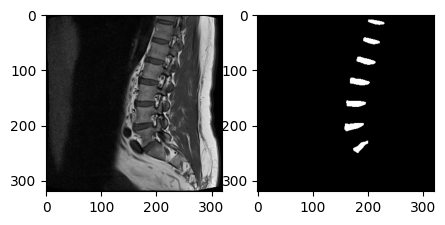

[dice: 0.918] [iou: 0.848]

[Epoch 262/300] [Batch 35/65] ETA: 0:02:56.454186
[Train_Dice: 0.062] [Train_dice: 0.938] [Train_iou: 0.883]


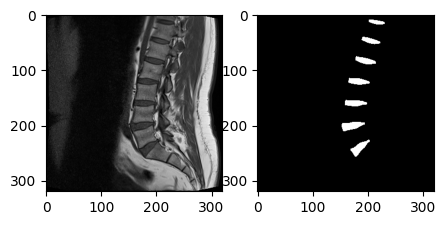

[dice: 0.939] [iou: 0.886]

[Epoch 266/300] [Batch 25/65] ETA: 0:02:29.957478
[Train_Dice: 0.067] [Train_dice: 0.933] [Train_iou: 0.874]


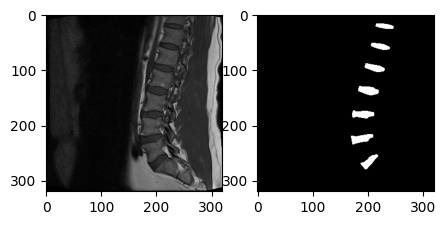

[dice: 0.932] [iou: 0.872]

[Epoch 270/300] [Batch 15/65] ETA: 0:02:21.032219
[Train_Dice: 0.054] [Train_dice: 0.946] [Train_iou: 0.897]


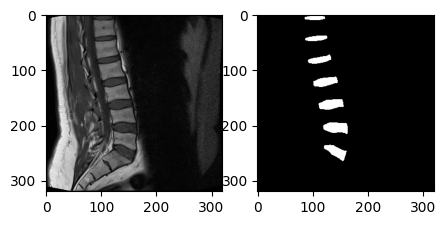

[dice: 0.923] [iou: 0.857]

[Epoch 274/300] [Batch 5/65] ETA: 0:02:03.598874
[Train_Dice: 0.064] [Train_dice: 0.936] [Train_iou: 0.880]


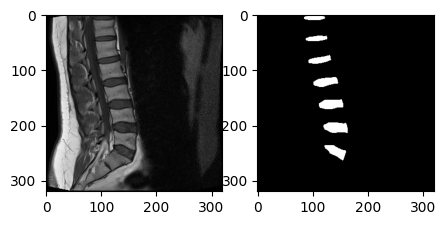

[dice: 0.936] [iou: 0.879]

[Epoch 277/300] [Batch 60/65] ETA: 0:01:47.173204
[Train_Dice: 0.055] [Train_dice: 0.945] [Train_iou: 0.897]


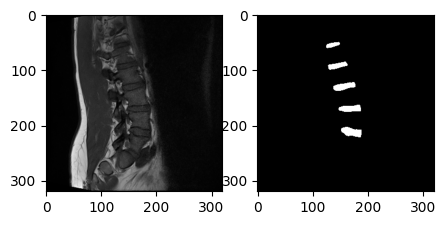

[dice: 0.898] [iou: 0.816]

[Epoch 281/300] [Batch 50/65] ETA: 0:01:29.483857
[Train_Dice: 0.058] [Train_dice: 0.942] [Train_iou: 0.892]


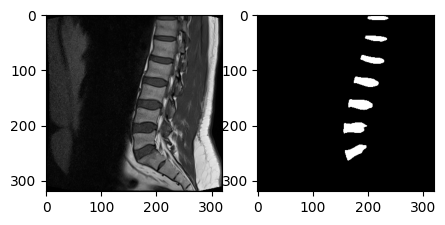

[dice: 0.919] [iou: 0.850]

[Epoch 285/300] [Batch 40/65] ETA: 0:01:12.435141
[Train_Dice: 0.063] [Train_dice: 0.937] [Train_iou: 0.882]


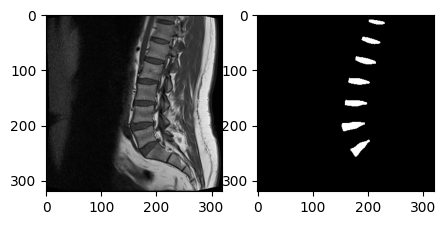

[dice: 0.947] [iou: 0.899]

[Epoch 289/300] [Batch 30/65] ETA: 0:00:54.836690
[Train_Dice: 0.062] [Train_dice: 0.938] [Train_iou: 0.884]


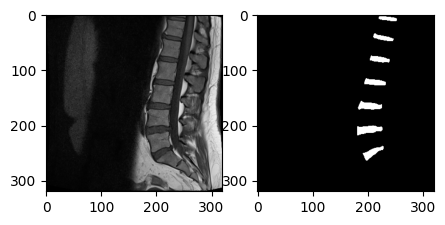

[dice: 0.917] [iou: 0.846]

[Epoch 293/300] [Batch 20/65] ETA: 0:00:35.791039
[Train_Dice: 0.061] [Train_dice: 0.939] [Train_iou: 0.885]


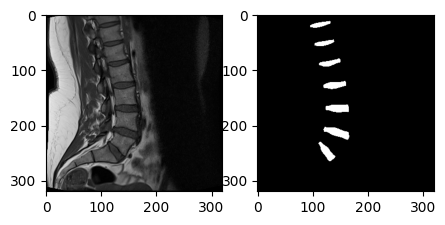

[dice: 0.927] [iou: 0.863]

[Epoch 297/300] [Batch 10/65] ETA: 0:00:17.892897
[Train_Dice: 0.059] [Train_dice: 0.941] [Train_iou: 0.889]


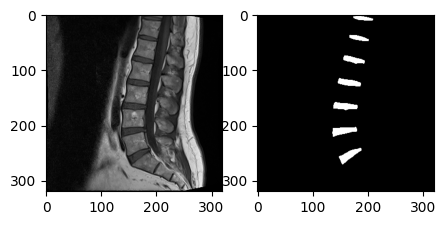

[dice: 0.929] [iou: 0.866]

Done Training the UNet !
Training Time: 1401.7542598247528 seconds


In [20]:
loss_hist = {'Train_Dice':[], 'Train_dice':[], 'Train_iou':[]} ## 18 or 15 'Train_Jaccard':[]

prev_time = time.time()
start_time = time.time()
train_losses = []
train_dices = []
train_iou = []
for epoch in range(NUM_EPOCHS):      
    model.train()         
    for i, imgs in enumerate(data_loader):                         
        inputs = Variable(imgs["stan"].type(Tensor)) 
        targets = Variable(imgs["mask"].type(Tensor))
        #inputs = inputs.repeat(1, 3, 1, 1) 
       
        optimizer.zero_grad()
        output = model(inputs) 
        #output = (output>0.5).float()
               
        dice = Dice(output, targets)
        iou = IoU(output, targets)
     
        Dice_loss = 1*criterion_Dice(output, targets)
        #Foc_loss = 10*criterion_F(output, targets)
        IOU_loss = 1*criterion_Jac(output, targets)
        
        losses = Dice_loss + IOU_loss #+ Foc_loss
      
        losses.backward()
        optimizer.step()  
        
        loss_hist['Train_Dice'].append(Dice_loss.item())
        #loss_hist['Train_Jaccard'].append(Jac_loss.item())
        loss_hist['Train_dice'].append(dice.item())
        loss_hist['Train_iou'].append(iou.item())
       
        # Determine approximate time left
        batches_done = epoch * len(data_loader) + i
        batches_left = NUM_EPOCHS * len(data_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
               
        if batches_done % sample_interval == 0:
            print("[Epoch %d/%d] [Batch %d/%d] ETA: %s" % (epoch+1, NUM_EPOCHS, i, len(data_loader), time_left))
            print("[Train_Dice: %.3f] [Train_dice: %.3f] [Train_iou: %.3f]" % # [Train_Jaccard: %.3f] Jac_loss.item()
                  (Dice_loss.item(), dice.item(), iou.item()))
            
            model.eval()

            dataiter1 = iter(test_loader)
            imgs_t = next(dataiter1) 
            tests = Variable(imgs_t["test"].type(Tensor)) 
            labels = Variable(imgs_t["label"].type(Tensor))
            #images = tests.repeat(1, 3, 1, 1) 
            #images = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(images)
            
            test_img = tests[0].clone().detach()#.unsqueeze(dim=0)
            test_img = ttoi(test_img)  
            gen_test = model(tests)#.detach().cpu() 
            
            sample_tensor = gen_test[0].clone().detach().unsqueeze(dim=0)
            tensor = sample_tensor.squeeze()
            sample_image = tensor.cpu().numpy()
            mask = np.copy(sample_image)
#             mask[np.nonzero(mask < 0.5)] = 0.0
#             mask[np.nonzero(mask >= 0.5)] = 1.
            #sample_image = ttoi(sample_tensor)
           
            show(test_img, mask)
        
            # Save Model
            checkpoint_path = work_dir+path_u + "checkpoint_" + str(epoch+1)+'_'+str(i) + ".pth"
            torch.save(model.state_dict(), checkpoint_path)
            
            test_loss = criterion_Dice(gen_test, labels)
            dice_val = Dice(gen_test, labels)
            iou_val = IoU(gen_test, labels)
            scheduler.step(test_loss)
            
            print("[dice: %.3f] [iou: %.3f]" % (dice_val, iou_val))
            print("")            
            model.train()
    del inputs 
    del targets
    torch.cuda.empty_cache()

stop_time = time.time()
# Print loss histories
print("Done Training the UNet !")
print("Training Time: {} seconds".format(stop_time-start_time))

In [ ]:
sample_tensor = targets.clone().detach().cpu()
sample_tensor.shape

In [78]:
inputs.shape

torch.Size([1, 3, 320, 320])